In [1]:

from datetime import datetime
import dask.diagnostics

import rioxarray
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
#import geojson
import json

from datetime import datetime

from shapely.geometry import mapping

#import zarr
import netCDF4

import os
import lxml

%matplotlib inline

import sys
import dask
import datacube

import matplotlib.pyplot as plt
from dask.distributed import Client

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_dask import create_local_dask_cluster


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
create_local_dask_cluster()

In [2]:
#!conda install netCDF4 --yes
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' #This is KEY! otherwise we send a bunch of HTTP GET requests to test for common sidecar metadata
os.environ['AWS_NO_SIGN_REQUEST']='YES' #Since this is a public bucket, we don't need authentication
os.environ['GDAL_MAX_RAW_BLOCK_CACHE_SIZE']='200000000'  #200MB: Want this to be greater than size of uncompressed raster to overcome a 10 MB limit in the GeoTIFF driver for range request merging.
os.environ['GDAL_SWATH_SIZE']='200000000'  #also increase this if increasing MAX_RAW_BLOCK_CACHE_SIZE
os.environ['VSI_CURL_CACHE_SIZE']='200000000' #also increase this if increasing MAX_RAW_BLOCK_CACHE_SIZE
# Others?

In [3]:
#!conda install lxml --yes
#!conda install -c conda-forge rtree=0.9.3 --yes  fixes geopandas lib spatial index dll error
filelisting_netcdf = 'https://s3-ap-southeast-2.amazonaws.com/silo-open-data/annual/index.html'

In [4]:
oz = xr.open_rasterio(f'https://s3-ap-southeast-2.amazonaws.com/silo-open-data/annual/rh_tmax/2020.rh_tmax.nc', chunks=(1,1024,1024))

In [5]:
oz

<xarray.DataArray (band: 366, y: 681, x: 841)>
dask.array<open_rasterio-cafea85b44866a7ff7ff930a2b7aa2a9<this-array>, shape=(366, 681, 841), dtype=int16, chunksize=(1, 681, 841), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
  * y        (y) float64 -10.0 -10.05 -10.1 -10.15 ... -43.85 -43.9 -43.95 -44.0
  * x        (x) float64 112.0 112.0 112.1 112.1 ... 153.8 153.9 153.9 154.0
Attributes:
    transform:   (0.05, 0.0, 111.975, 0.0, -0.05, -9.975)
    res:         (0.05, 0.05)
    is_tiled:    0
    nodatavals:  (-32767.0, -32767.0, -32767.0, -32767.0, -32767.0, -32767.0,...
    scales:      (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...
    offsets:     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
    units:       ('%', '%', '%', '%', '%', '%', '%', '%', '%', '%', '%', '%',...

In [11]:
with dask.diagnostics.ProgressBar():
    oz = oz.where(oz > -32767.0, drop=True)

[########################################] | 100% Completed |  0.8s


In [12]:
oz.min()

<xarray.DataArray ()>
dask.array<nanmin-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [13]:
oz[74].mean().compute()

<xarray.DataArray ()>
array(322.34455585)
Coordinates:
    band     int64 75

In [14]:
oz[200].mean().compute()

<xarray.DataArray ()>
array(361.83599267)
Coordinates:
    band     int64 201

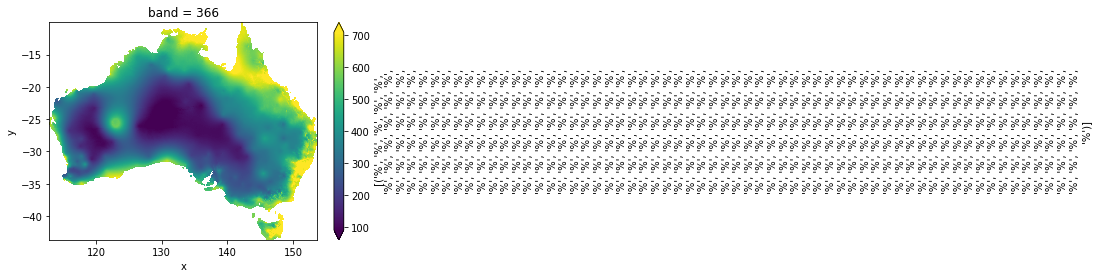

In [15]:
oz[365].plot(robust=True)

In [16]:
oz[200].shape

(663, 816)

In [17]:
np.unique(oz[200].values, return_counts=True)

(array([78., 79., 80., ..., nan, nan, nan]),
 array([ 6, 12, 42, ...,  1,  1,  1]))

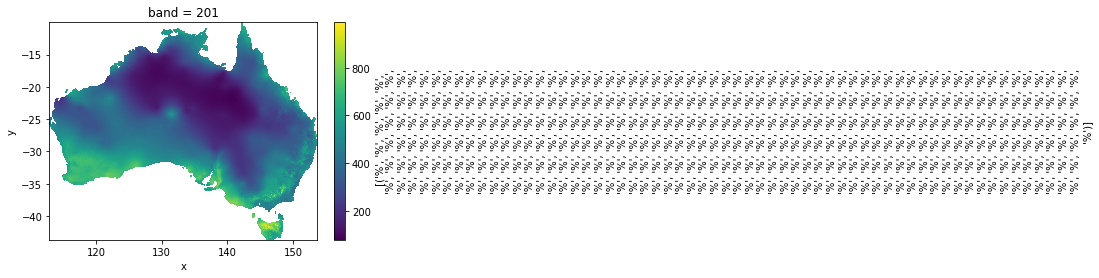

In [18]:
oz[200].plot()

In [ ]:
oz.rio.to_raster(r'humid.tif')